**Importing necessary libraries**

In [11]:
import torch
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile
from IPython.display import Audio
from sklearn.kernel_approximation import RBFSampler


%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

**Loading the audio**

In [12]:
audio, sr = torchaudio.load('/Users/shreya/Documents/fork-it/assignment2/Task_2/sample_audio.wav')
print("audio shape: ", audio.shape)
print("sample rate: ",{sr})

audio shape:  torch.Size([1, 220500])
sample rate:  {44100}


In [13]:
audio_length = audio.shape[1] / sr
print("audio length is", audio_length, "sec")

audio length is 5.0 sec


In [14]:
audio
audio.shape

torch.Size([1, 220500])

**Plotting Audio**

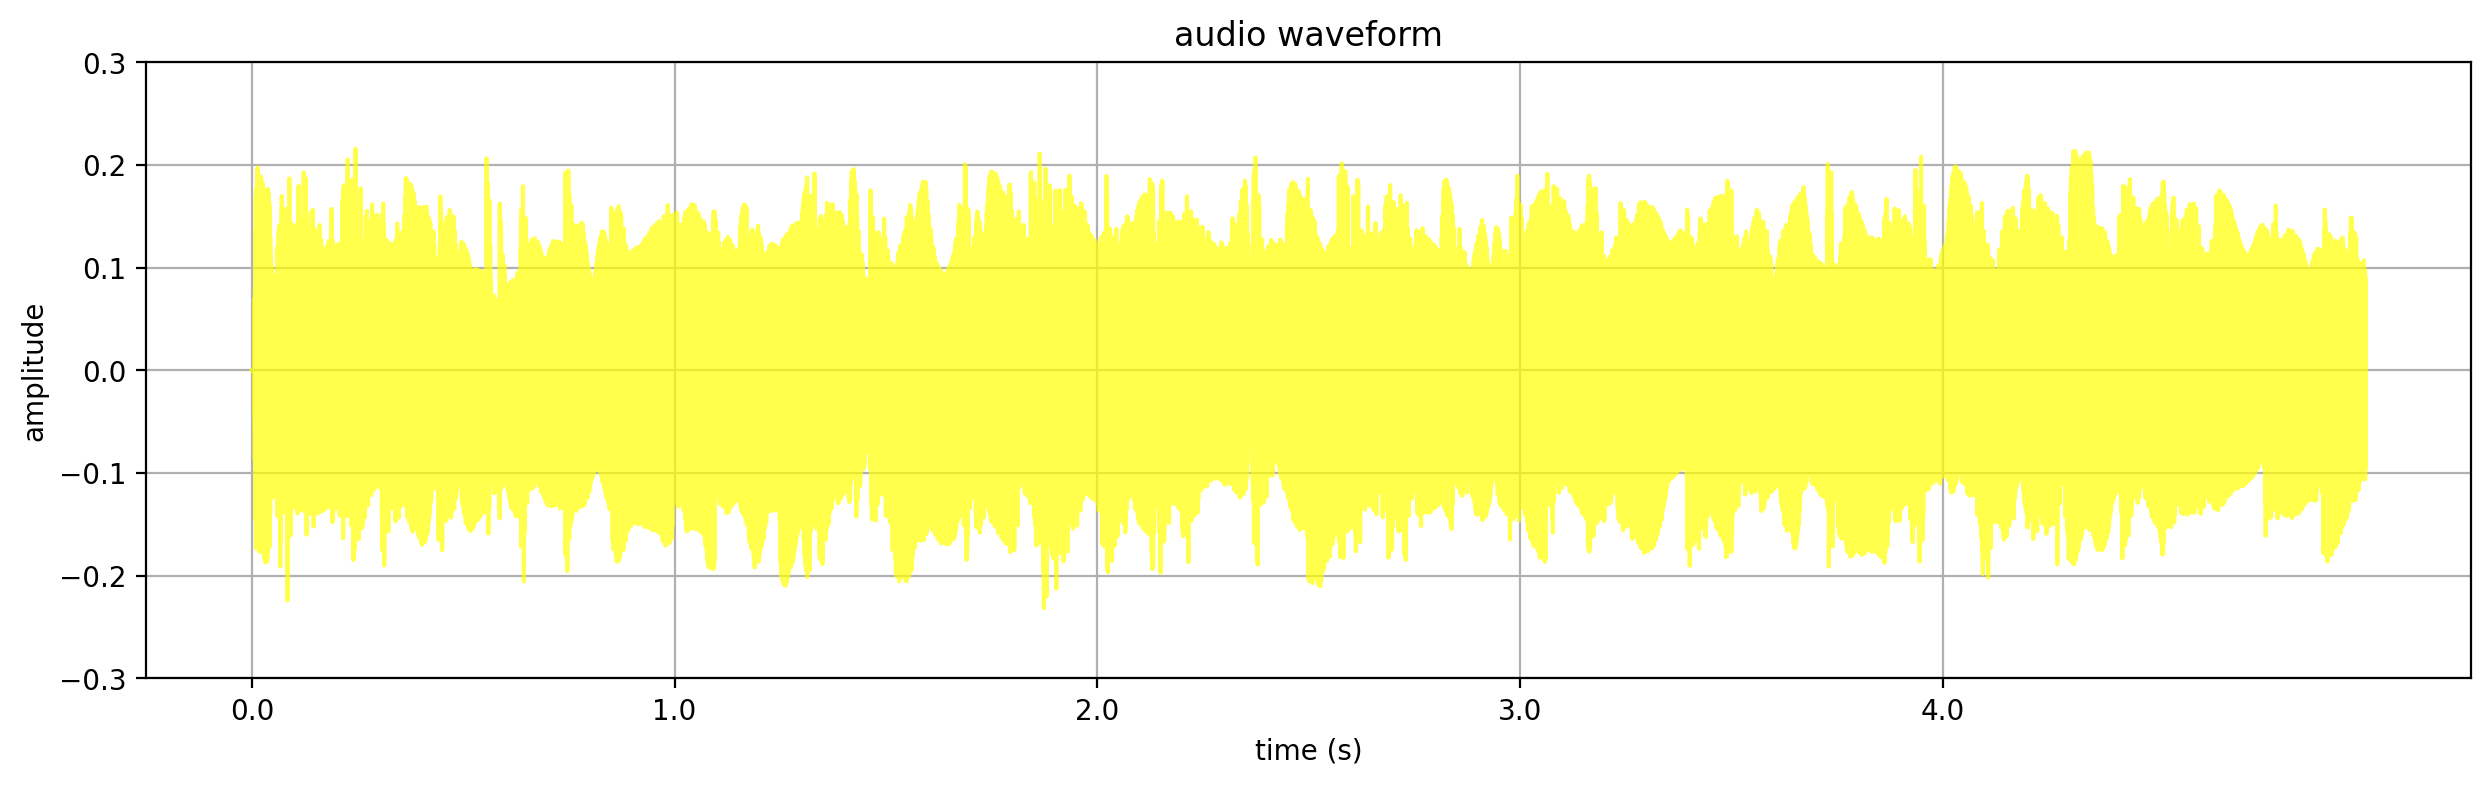

In [19]:
sr = 44100
audio_np = audio.squeeze().numpy()
plt.figure(figsize=(15, 4))
plt.plot(audio_np, color='yellow', alpha=0.7)
num_samples = len(audio_np)
xticks = np.arange(0, num_samples, sr)  
xticklabels = np.arange(0, num_samples / sr, 1)
plt.xticks(xticks, xticklabels)
plt.ylim(-0.3, 0.3)  
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('audio waveform')
plt.grid()
plt.show()

**Playing the audio**

In [30]:
Audio(audio, rate=sr)


**Using last 2 seconds of the Sample Audio**

In [31]:
audio_trim = audio [:,-2*sr:]
print(audio_trim.shape)
print(audio_trim)

torch.Size([1, 88200])
tensor([[ 0.0151, -0.0408, -0.0940,  ..., -0.0068, -0.0126, -0.0204]])


**Plotting the last 2 seconds of the Sample Audio**

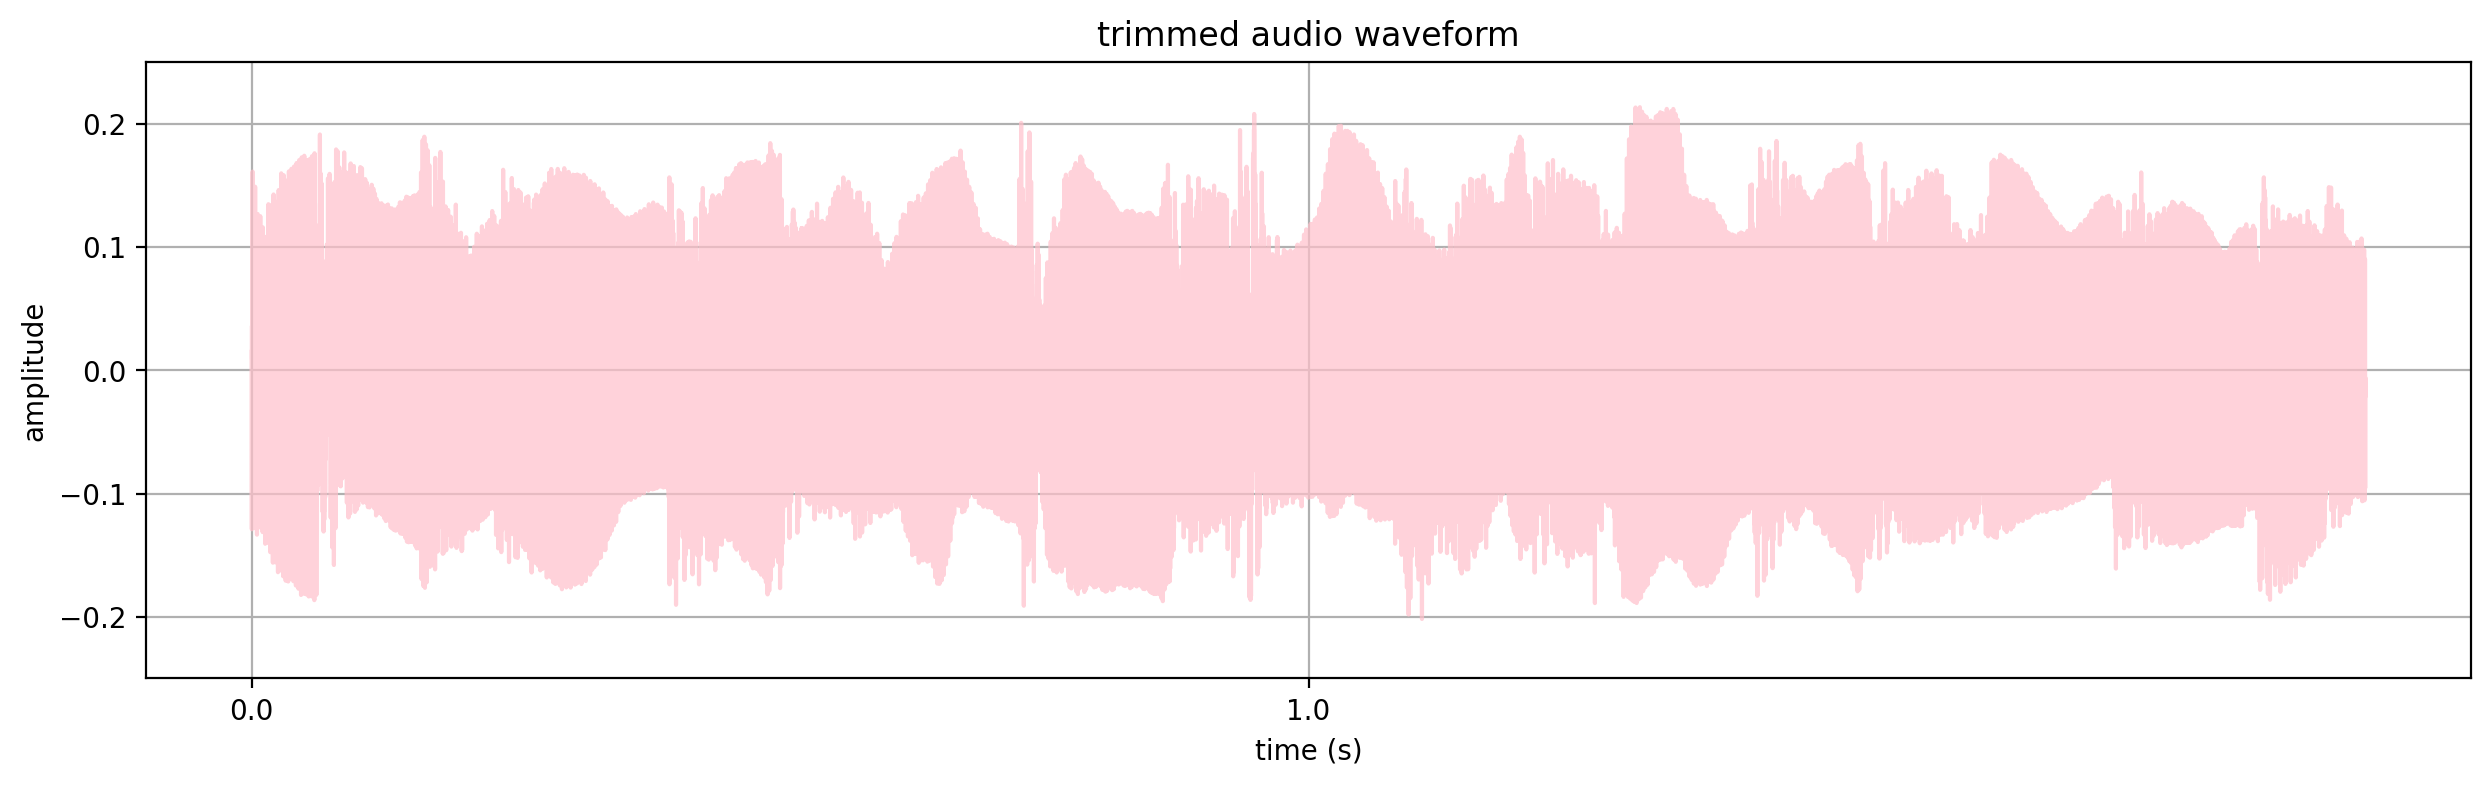

In [58]:
sr = 44100
audio_trim_np = audio_trim.squeeze().numpy()
plt.figure(figsize=(15, 4))
plt.plot(audio_trim_np, color='pink', alpha=0.7)
num_samples = len(audio_trim_np)
xticks = np.arange(0, num_samples, sr)  
xticklabels = np.arange(0, num_samples / sr, 1)
plt.xticks(xticks, xticklabels)
plt.ylim(-0.25, 0.25)  
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('trimmed audio waveform')
plt.grid()
plt.show()

**Playing the trimmed audio**

In [34]:
Audio(audio_trim, rate=sr)

**Normalization, Scaling and Shifting**

In [35]:
X = torch.arange(0, audio_trim.shape[1]).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([88200, 1])
tensor([[-100.0000],
        [ -99.9977],
        [ -99.9955],
        ...,
        [  99.9955],
        [  99.9977],
        [ 100.0000]])


**Transforming input features into new features using Random Fourier Features**

In [37]:
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma**2), random_state=13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

In [39]:
X_rff = create_rff_features(X, 5000, 0.008)
print(X_rff.shape)
print(X_rff)

torch.Size([88200, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0050, -0.0194, -0.0189,  ..., -0.0198,  0.0093, -0.0090],
        [ 0.0011, -0.0200, -0.0189,  ..., -0.0199,  0.0113, -0.0124],
        ...,
        [-0.0141, -0.0200, -0.0148,  ...,  0.0045, -0.0043, -0.0085],
        [-0.0110, -0.0196, -0.0146,  ...,  0.0057, -0.0019, -0.0119],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


In [40]:
print("X_rff shape:", X_rff.shape)
print("audio_trim shape:", audio_trim.shape)

X_rff shape: torch.Size([88200, 5000])
audio_trim shape: torch.Size([1, 88200])


In [41]:
#reshaping audio_trim to be a 1D tensor
audio_trim_1D = audio_trim.squeeze()

#checking the shapes
print(f"X_rff shape: {X_rff.shape}")
print(f"audio_trim_1d shape: {audio_trim_1D.shape}")

X_rff shape: torch.Size([88200, 5000])
audio_trim_1d shape: torch.Size([88200])


**Fitting a linear model over the expanded feature domain**

In [42]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio_trim_1D)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(88200,)


**Saving the predicted audio**

In [43]:
soundfile.write('pred_audio.wav', pred_audio, sr)

In [44]:
print(pred_audio)
print(audio)

[-0.08306604 -0.07054751 -0.05531597 ...  0.01728127  0.01008498
 -0.00305414]
tensor([[ 0.0000e+00,  3.0518e-05, -6.1035e-05,  ..., -6.8054e-03,
         -1.2634e-02, -2.0386e-02]])


**Playing the predicted audio**

In [45]:
Audio(pred_audio, rate=sr)

In [46]:
#flattening audio to 1D
audio_flat = audio_trim.numpy().flatten()

**Computing Reconstruction Losses using L1 and L2 norms**

In [47]:
# checking if the lengths match (debugging step)
print(pred_audio.shape, audio_flat.shape)

L2_norm = np.linalg.norm(pred_audio - audio_flat)
L1_norm = np.linalg.norm(pred_audio - audio_flat, ord=1)

print("L1 Norm", L1_norm)
print("L2 Norm:", L2_norm)

(88200,) (88200,)
L1 Norm 4197.2573
L2 Norm: 17.423702


**Plotting Reconstructed Audio**

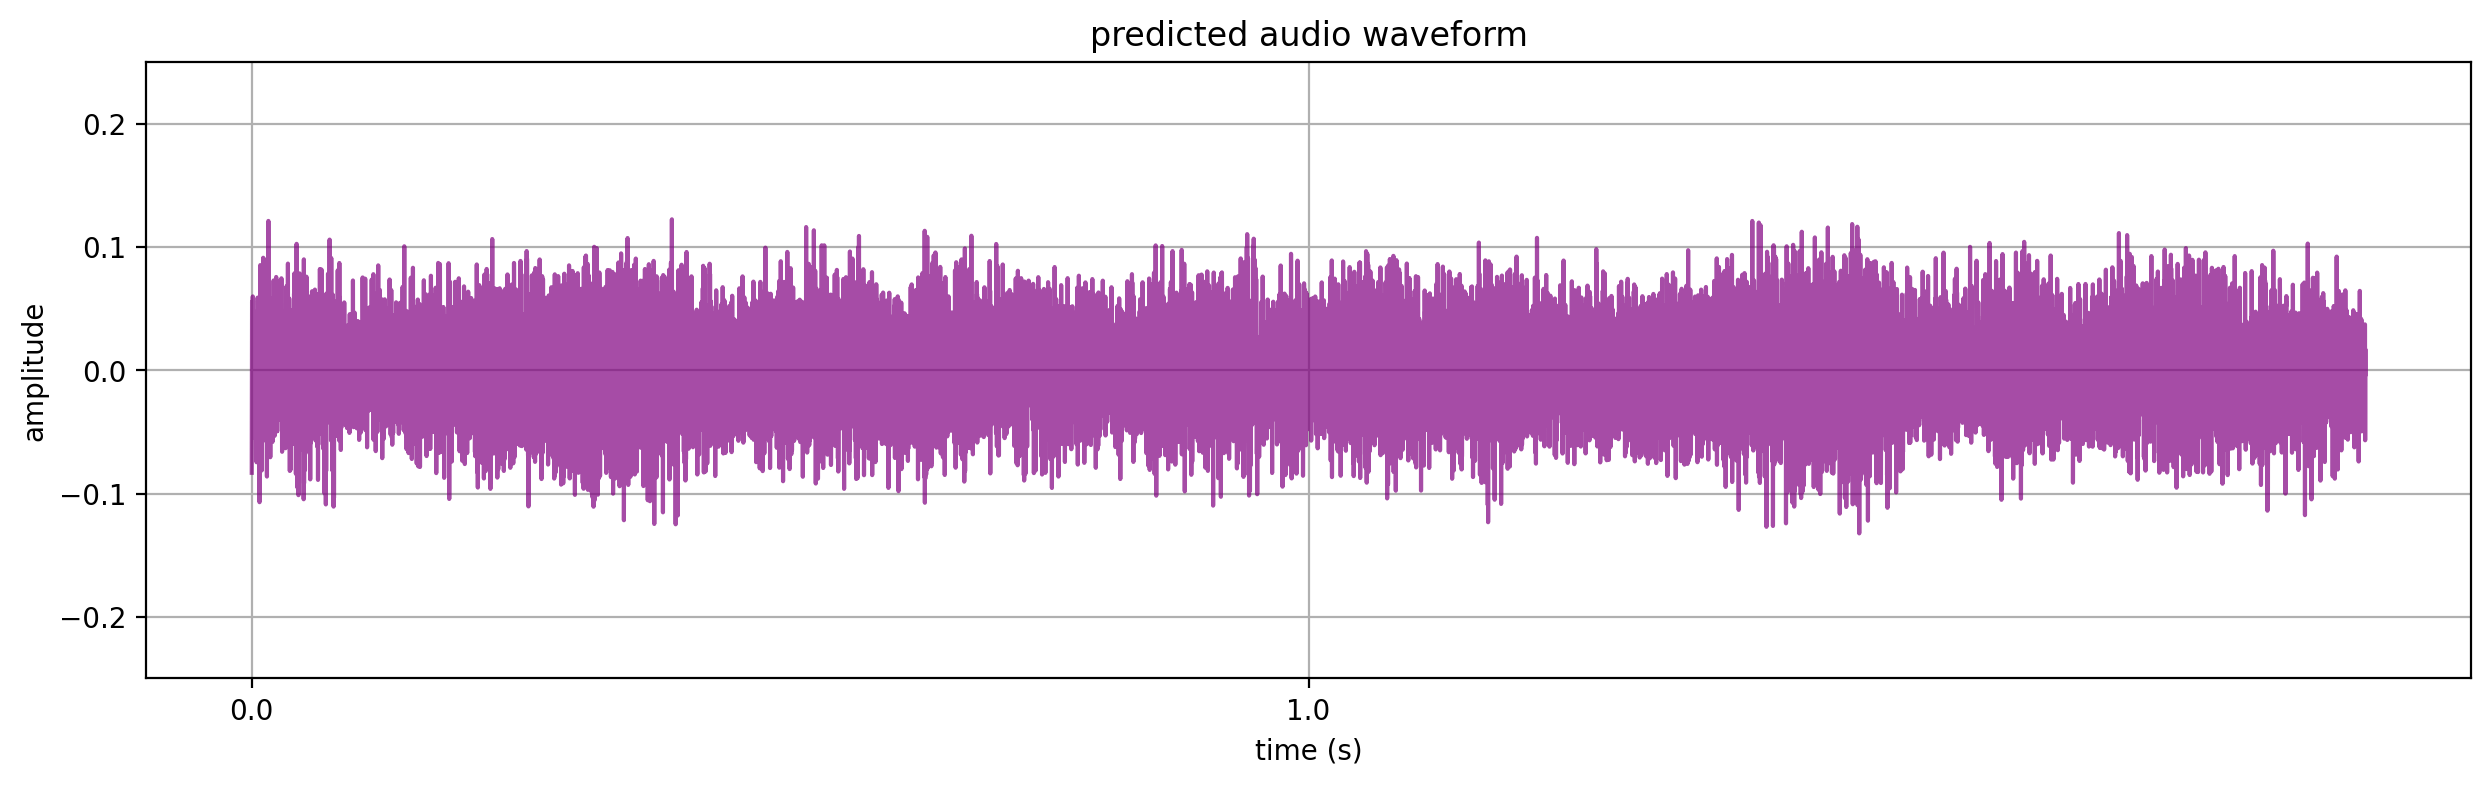

In [57]:
sr = 44100
plt.figure(figsize=(15, 4))
plt.plot(pred_audio, color='purple', alpha=0.7)
num_samples = len(pred_audio)
xticks = np.arange(0, num_samples, sr)  
xticklabels = np.arange(0, num_samples / sr, 1)
plt.xticks(xticks, xticklabels)
plt.ylim(-0.25, 0.25)  
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('predicted audio waveform')
plt.grid()
plt.show()

**Comparing the plots of original audio and reconstructed audio**

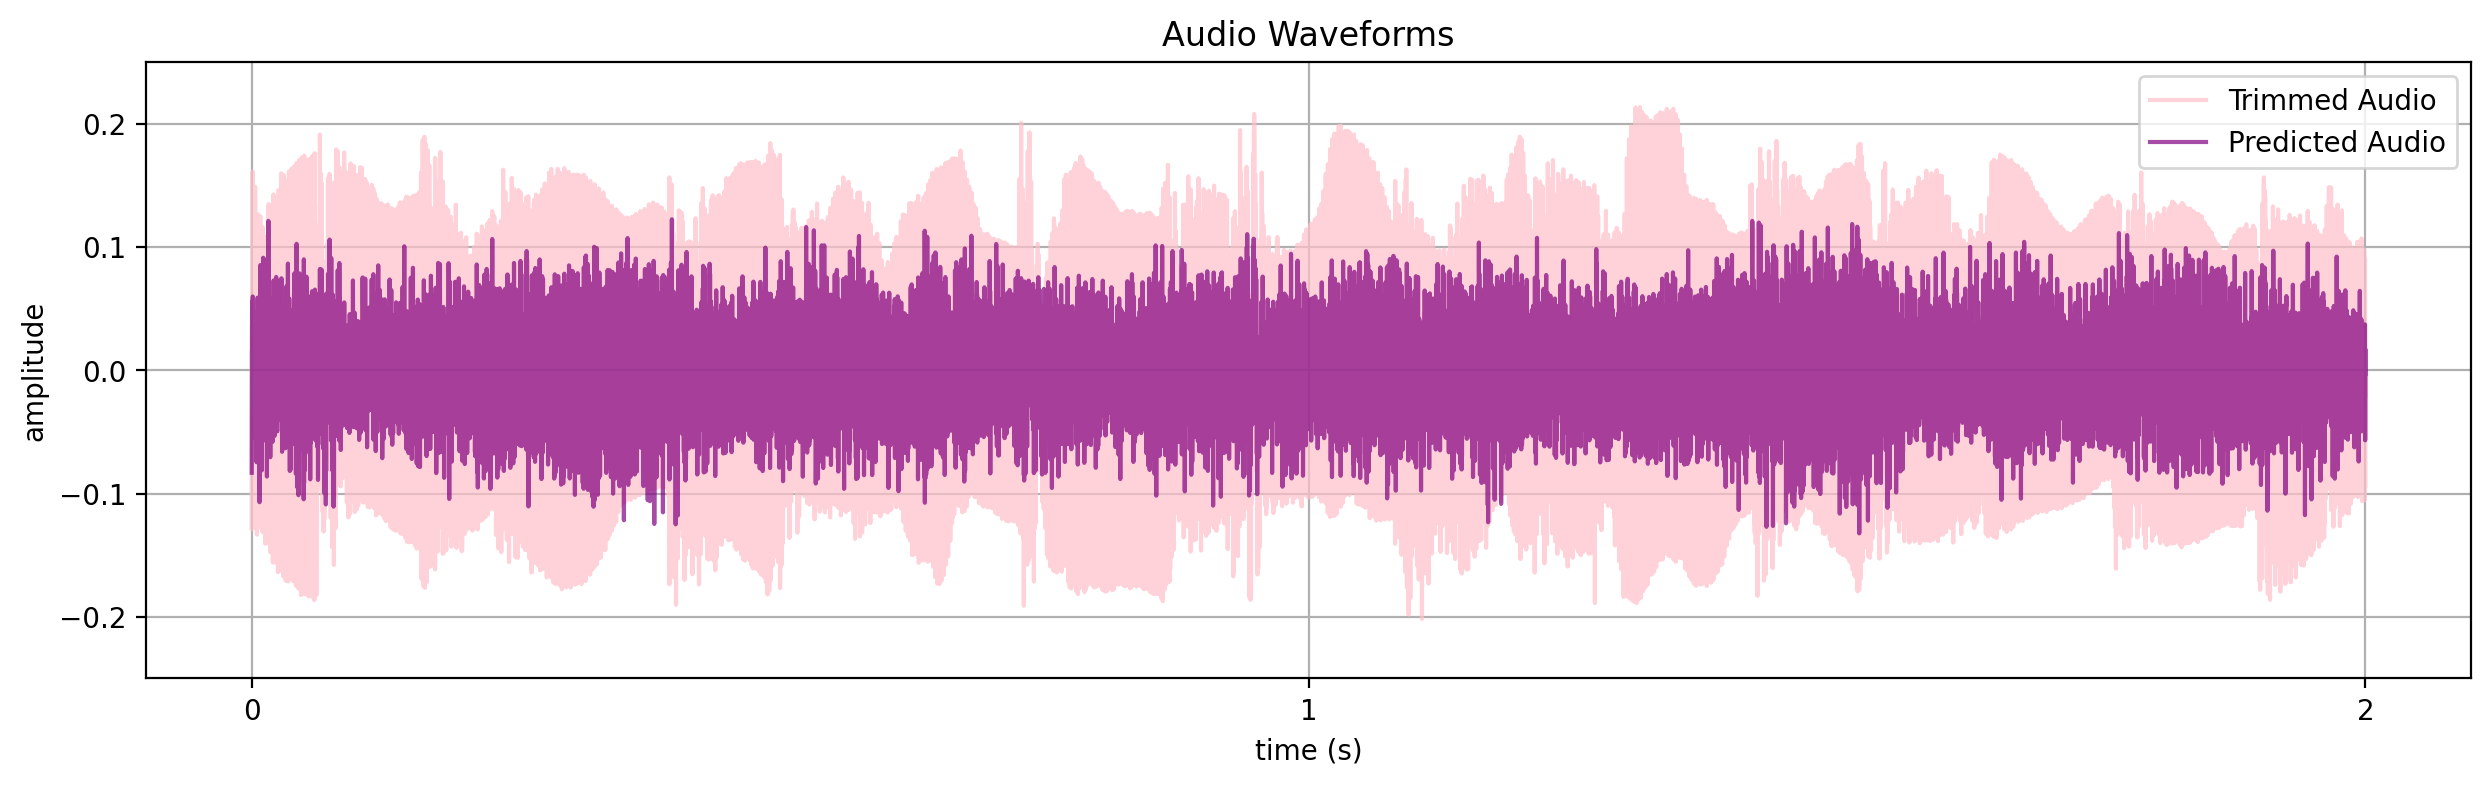

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Sample rate
sr = 44100

# Convert audio data to NumPy arrays if not already
audio_trim_np = audio_trim.squeeze().numpy()
pred_audio_np = pred_audio.squeeze()  # Assuming pred_audio is already a NumPy array

# Create a new figure
plt.figure(figsize=(15, 4))

# Plot the trimmed audio
plt.plot(audio_trim_np, color='pink', alpha=0.7, label='Trimmed Audio')

# Plot the predicted audio
plt.plot(pred_audio_np, color='purple', alpha=0.7, label='Predicted Audio')

# Number of samples
num_samples_trim = len(audio_trim_np)
num_samples_pred = len(pred_audio_np)

# Set up x-ticks and x-tick labels
# Define step size for ticks
step_size = sr
xticks = np.arange(0, max(num_samples_trim, num_samples_pred) + step_size, step_size)
xticklabels = np.arange(0, len(xticks))

plt.xticks(xticks, xticklabels)
plt.ylim(-0.25, 0.25)  # Adjust y-limits if necessary
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('Audio Waveforms')
plt.legend()
plt.grid()
plt.show()


**Calculating RMSE**

In [59]:
rmse_val = np.sqrt(np.mean((audio_flat - pred_audio) ** 2))
print("Root Mean Square Value: ", rmse_val)

Root Mean Square Value:  0.058668658


In [65]:
signal_pow = np.sum(audio_flat ** 2)
noise_pow = np.sum((audio_flat - pred_audio) ** 2)
snr = 10 * np.log10(signal_pow / noise_pow)
print("Signal to Noise Ratio :", snr,"dB")

Signal to Noise Ratio : 1.2668275 dB
